# Global preparations

In [200]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:5'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
logger = logging.getLogger('stdout_logger')
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(logging.Formatter(fmt='%(asctime)s|%(levelname)s|%(message)s'))
    logger.addHandler(stdout_handler)

# MNIST preparation

Let's read the MNIST dataset and represent it in sparse form

In [201]:
mnist_dataset_dir = 'mnist'

import torchvision.transforms as T

transform = T.Normalize((0.1307,), (0.3081,))

mnist_train_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=True, download=True
)
mnist_test_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=False, download=True
)
mnist_train_data_device = mnist_train_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_test_data_device = mnist_test_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_train_targets_device = mnist_train_dataset.targets.to(device=device)
mnist_test_targets_device = mnist_test_dataset.targets.to(device=device)

# mnist_train_dataset = TensorDataset(
#     transform(mnist_train_data_device), mnist_train_targets_device
# )
# mnist_test_dataset = TensorDataset(
#     transform(mnist_test_data_device), mnist_test_targets_device
# )

mnist_train_dataset = TensorDataset(
    mnist_train_data_device, mnist_train_targets_device
)
mnist_test_dataset = TensorDataset(
    mnist_test_data_device, mnist_test_targets_device
)

In [202]:
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_train_dataset,
    batch_size=10, shuffle=True
)

example_data, example_targets = next(iter(mnist_test_loader))
to_pil_image(example_data[0])

In [203]:
patch_h = patch_w = 28
input_shape = (patch_h, patch_w)
clustering_dim = 44

In [204]:
example_data.shape

torch.Size([10, 28, 28])

# Baseline MLP

In [205]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class BaselineMLP(nn.Module):
    def __init__(self, device, n_inputs, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_dim, bias=False, device=device)
        self.fc2 = nn.Linear(hidden_dim, 10, bias=False, device=device)
        
    def forward(self, x):
        x1 = x / (x.norm(dim=-1, keepdim=True) + 1e-16)
        x2 = F.relu(self.fc1(x1))
        return self.fc2(x2)
    
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc = nn.Linear(128 * 7 * 7, 10)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.max_pool2d(x, 2)      # 28→14
        x = F.relu(self.c3(x))
        x = F.max_pool2d(x, 2)      # 14→7
        x = x.flatten(1)
        return self.fc(self.drop(x))

In [206]:
baseline_net = BaselineMLP(device, input_shape[0] * input_shape[1], clustering_dim**2)

In [125]:
baseline_net = MNIST_CNN()
baseline_net.to(device=device)

# Count parameters
total_params = sum(p.numel() for p in baseline_net.parameters())
trainable_params = sum(p.numel() for p in baseline_net.parameters() if p.requires_grad)

print(f"Baseline Model: {baseline_net}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Baseline Model: MNIST_CNN(
  (c1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=6272, out_features=10, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)
Total parameters: 155,402
Trainable parameters: 155,402


In [9]:
optimizer = optim.Adam(baseline_net.parameters(), lr=0.0003)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    baseline_net.train()
    train_loader = torch.utils.data.DataLoader(
        mnist_train_dataset, batch_size=64, shuffle=True,
        
    )
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = baseline_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    baseline_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = baseline_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

Epoch 1 Train/test accuracy: 93.03/98.20
Epoch 2 Train/test accuracy: 98.07/98.74
Epoch 3 Train/test accuracy: 98.54/98.77
Epoch 4 Train/test accuracy: 98.78/99.06
Epoch 5 Train/test accuracy: 99.03/99.13
Epoch 6 Train/test accuracy: 99.16/99.19
Epoch 7 Train/test accuracy: 99.27/99.04


KeyboardInterrupt: 

# Simple ANDN network

#### Similar to *Krotov,Hopfield, 2019 "Unsupervised Learning by Competing Hidden Units"*

In [17]:
from spiky.andn.ANDNLayer import Conv2DANDNLayer, SynapseMeta

receptive_field_shape=(28, 28)
receptive_field_stride_shape=(28, 28)
output_kernel_shape=(clustering_dim, clustering_dim)
final_output_shape = (1, 10)
synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=10.0,
    initial_weight=1.0,
    initial_noise_level=-10.0
)

synapse_meta_2 = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-2.0
)

class ANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.layer1 = Conv2DANDNLayer(
            input_shape=input_shape,
            inhibition_grid_shape=None,
            receptive_field_shape=receptive_field_shape,
            receptive_field_stride_shape=receptive_field_stride_shape,
            output_kernel_shape=output_kernel_shape,
            backprop_hebb_ratio_on_torch_backward=0.5,
            #anti_hebb_coeff=0.4,
            synapse_meta=synapse_meta_1,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer2 = Conv2DANDNLayer(
            input_shape=self.layer1.output_shape(),
            inhibition_grid_shape=output_kernel_shape,
            receptive_field_shape=self.layer1.output_shape(),
            receptive_field_stride_shape=self.layer1.output_shape(),
            output_kernel_shape=final_output_shape,
            backprop_hebb_ratio_on_torch_backward=0.0,
            synapse_meta=synapse_meta_2,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        self.layer1.set_descendant_andn_layer(self.layer2)

    def forward(self, x):
        x = x / (x.norm(dim=(-1, -2), keepdim=True) + 1e-16)
        return self.layer2(self.layer1(x)).squeeze(1)

In [19]:
andn_net = ANDNNet(device)
andn_net

ANDNNet(
  (layer1): ANDNLayer(784 inputs, 0 detectors, 1936 outputs, 1517824 synapses, ANDNDataManager(host_device: 28258188, 18849672; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 1517824; n_detectors: 0; first_synapse_id: 229136; last_synapse_id: 6494852; n_forward_groups: 24304; n_backward_groups: 25168))
  (layer2): ANDNLayer(1936 inputs, 1 detectors, 10 outputs, 19360 synapses, ANDNDataManager(host_device: 702876, 476368; host_only: 1024, 48; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 19360; n_detectors: 1; first_synapse_id: 218304; last_synapse_id: 311220; n_forward_groups: 1936; n_backward_groups: 310))
)

In [21]:
optimizer = optim.Adam(andn_net.parameters(), lr=0.001)
#optimizer = optim.SGD(andn_net.parameters(), lr=0.001, momentum=0.95)

loss_func = nn.CrossEntropyLoss()
for epoch in range(16):
    andn_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # target_one_hot = torch.nn.functional.one_hot(target, num_classes=10)
        optimizer.zero_grad()
        output = andn_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    
    andn_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = andn_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

Epoch 1 Train/test accuracy: 94.97/94.42
Epoch 2 Train/test accuracy: 95.24/94.64
Epoch 3 Train/test accuracy: 94.98/94.46
Epoch 4 Train/test accuracy: 94.97/95.11
Epoch 5 Train/test accuracy: 95.17/94.78
Epoch 6 Train/test accuracy: 95.41/95.17
Epoch 7 Train/test accuracy: 95.51/95.28
Epoch 8 Train/test accuracy: 95.53/95.44
Epoch 9 Train/test accuracy: 95.53/95.29
Epoch 10 Train/test accuracy: 95.70/95.32
Epoch 11 Train/test accuracy: 95.52/95.33
Epoch 12 Train/test accuracy: 95.42/95.01
Epoch 13 Train/test accuracy: 95.58/95.39
Epoch 14 Train/test accuracy: 95.58/95.32
Epoch 15 Train/test accuracy: 95.64/95.40
Epoch 16 Train/test accuracy: 95.68/95.35


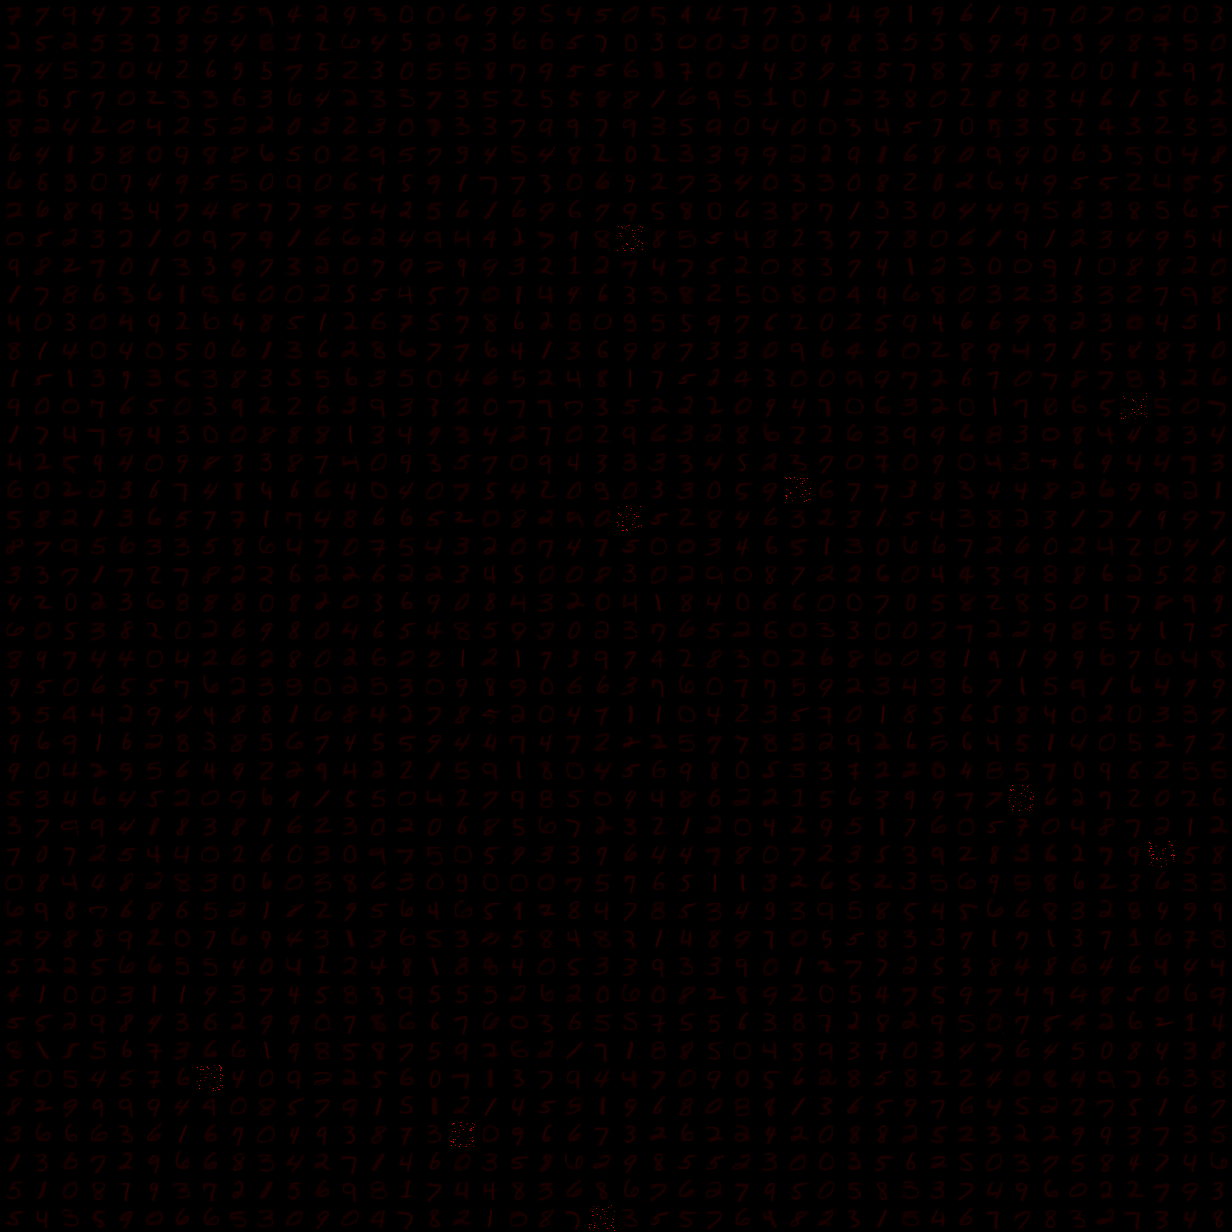

In [22]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

output_shape = andn_net.layer1.output_shape()
target_image = torch.zeros([output_shape[0] * (patch_h + 2), output_shape[1] * (patch_w + 2)])
weights = andn_net.layer1.export_weights()

for i in range(output_shape[0]):
    for j in range(output_shape[1]):
        target_image[
            i * (patch_h + 2) + 1:i * (patch_h + 2) + patch_h + 1,
            j * (patch_w + 2) + 1:j * (patch_w + 2) + patch_w + 1
        ] = weights[i, j]

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        output_shape[0] * receptive_field_shape[0], 
        output_shape[1] * receptive_field_shape[1]
    ], Image.NEAREST
)

# Layered ANDN network

In [207]:
def uniform_sparsity_mask(H, W, alpha, device):
    return torch.rand(H, W, device=device) < alpha

def normal_sparsity_mask(H, W, alpha, device, sigma=4.0):
    yy, xx = torch.meshgrid(
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing="ij",
    )

    cy = (H - 1) / 2.0
    cx = (W - 1) / 2.0

    # choose spread (std dev) in pixels
    sigma_y = H / sigma
    sigma_x = W / sigma

    p = torch.exp(-0.5 * (((yy - cy) / sigma_y) ** 2 + ((xx - cx) / sigma_x) ** 2))
    p = p * (alpha / p.mean())          # match average probability ~ alpha
    p = p.clamp(0.0, 1.0)

    return (torch.rand(H, W, device=device) < p)

In [303]:
from spiky.lut.ANDNLUTLayer import ANDNLUTLayerEx
from spiky.lut.LUTLayer import GradientPolicy, GradientType, LUTSharedContext, LUTLayerBasic, LUTLayer
from spiky.util.synapse_growth import PointSamplingPolicy, PointSamplingType
from spiky.andn.ANDNLayer import SynapseMeta

input_shape=(28, 28)
final_output_shape = (1, 10)
synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=5.0,
    initial_weight=5.0,
    initial_noise_level=-5.0
)

# synapse_meta_1 = SynapseMeta(
#     min_weight=0.0,
#     max_weight=1.0,
#     initial_weight=0.0,
#     initial_noise_level=0.0
# )

# synapse_meta_2 = SynapseMeta(
#     min_weight=-1.0,
#     max_weight=1.0,
#     initial_weight=0.0,
#     initial_noise_level=0.0
# )

shared_lut_ctx = LUTSharedContext()
shared_lut_ctx.to_device(device)
g_policy = GradientPolicy(GradientType.Dense, normalized=False)


class LUTANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        #sp_mask_1 = uniform_sparsity_mask(input_shape[0] * 2, input_shape[1] * 2, 0.2, device)
        sp_mask_1 = None
        self.layer1 = ANDNLUTLayerEx(
            input_shape=input_shape,
            output_shape=(input_shape[0] * 2, input_shape[1] * 2),
            n_anchors_per_detector=3,
            n_detector_groups=256,
            n_detectors_in_group=4,
            receptive_shape=(5, 5),
            projection_shape=(10, 10),
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=16, grid_w=16
            ),
            output_sparsity_mask=sp_mask_1,
            inhibition_window_shape=(3, 3),
            n_inhibitors=1024,
            n_neurons_per_inhibitor=9,
            dropout=0.0,
            synapse_meta=synapse_meta_1,
            do_normalize_weights=True,
            backprop_hebb_ratio_on_torch_backward=0.0,
            anti_hebb_coeff=0.0,
            relu_before_inhibition=True,
            residual=False,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
        #sp_mask_2 = uniform_sparsity_mask(input_shape[0], input_shape[1], 0.2, device)
        sp_mask_2 = None
        self.layer2 = ANDNLUTLayerEx(
            input_shape=(input_shape[0] * 2, input_shape[1] * 2),
            output_shape=(input_shape[0], input_shape[1]),
            n_anchors_per_detector=5,
            n_detector_groups=64,
            n_detectors_in_group=16,
            receptive_shape=(20, 20),
            projection_shape=(5, 5),
            input_sparsity_mask=sp_mask_1,
            output_sparsity_mask=sp_mask_2,
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=8, grid_w=8
            ),
            inhibition_window_shape=(3, 3),
            n_inhibitors=0,
            n_neurons_per_inhibitor=9,
            dropout=0.0,
            synapse_meta=synapse_meta_1,
            do_normalize_weights=True,
            backprop_hebb_ratio_on_torch_backward=0.0,
            anti_hebb_coeff=0.0,
            relu_before_inhibition=True,
            residual=False,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed + 1,
            device=device
        )

#         self.layer2 = LUTLayer(
#             n_inputs=input_shape[0] * 2 * input_shape[1] * 2,
#             n_outputs=64,
#             n_detectors=256,
#             n_anchors_per_detector=8,
#             sequence_length=1,
#             weights_gradient_policy=g_policy,
#             shared_context=shared_lut_ctx,
#             summation_dtype=summation_dtype,
#             device=device,
#             random_seed=random_seed,
#         )

        osh = self.layer2._andn_layer.output_shape()
        #osh = (8, 8)
        self.final_layer = nn.Linear(osh[0] * osh[1], final_output_shape[1], device=device)
        self._l1_res = None
        self._l2_res = None
        # self.final_layer = nn.Linear(28 * 28, final_output_shape[1], device=device)

    def forward(self, x):
        self._l1_res = self.layer1(
            x.unsqueeze(1)
        )
        
        # self._l2_res = self.layer2(self._l1_res.reshape(x.shape[0], -1).unsqueeze(1))
        self._l2_res = self.layer2(self._l1_res.unsqueeze(1))
    
        return self.final_layer(
            self._l2_res.view(x.shape[0], -1)
        )

In [304]:
layered_andn_net = LUTANDNNet(device)
layered_andn_net.layer1._andn_layer._normalize_backprop_gradients = False
layered_andn_net

LUTANDNNet(
  (layer1): ANDNLUTLayerEx(input_shape=(28, 28), output_shape=(1, 8192), n_detectors=1024, n_anchors_per_detector=3)
  (layer2): ANDNLUTLayerEx(input_shape=(56, 56), output_shape=(1, 32768), n_detectors=1024, n_anchors_per_detector=5)
  (final_layer): Linear(in_features=784, out_features=10, bias=True)
)

In [305]:
# Count parameters
lut_total_params = sum(p.numel() for p in layered_andn_net.parameters())
lut_trainable_params = sum(p.numel() for p in layered_andn_net.parameters() if p.requires_grad)

print(f"LUTNet Model: {layered_andn_net}")
print(f"Total parameters: {lut_total_params:,}")
print(f"Trainable parameters: {lut_trainable_params:,}")

LUTNet Model: LUTANDNNet(
  (layer1): ANDNLUTLayerEx(input_shape=(28, 28), output_shape=(1, 8192), n_detectors=1024, n_anchors_per_detector=3)
  (layer2): ANDNLUTLayerEx(input_shape=(56, 56), output_shape=(1, 32768), n_detectors=1024, n_anchors_per_detector=5)
  (final_layer): Linear(in_features=784, out_features=10, bias=True)
)
Total parameters: 1,910,466
Trainable parameters: 1,910,466


In [306]:
layered_andn_net(example_data)

tensor([[ 0.2973, -0.7206,  0.0531, -0.0129,  0.8075, -0.2409, -0.6921, -0.1258,
         -0.3551, -0.4838],
        [ 0.2919, -0.7235,  0.0919,  0.0106,  0.8087, -0.2821, -0.7527, -0.1136,
         -0.3466, -0.4737],
        [ 0.3346, -0.7499,  0.0839, -0.0437,  0.8043, -0.2696, -0.6980, -0.1180,
         -0.3300, -0.4521],
        [ 0.3288, -0.7112,  0.0542, -0.0148,  0.7773, -0.2769, -0.6951, -0.1320,
         -0.3370, -0.4978],
        [ 0.3024, -0.7353,  0.0772, -0.0224,  0.8375, -0.2721, -0.6961, -0.1366,
         -0.3463, -0.5029],
        [ 0.2937, -0.7216,  0.0540, -0.0037,  0.8285, -0.2529, -0.7093, -0.1151,
         -0.3771, -0.4958],
        [ 0.3421, -0.7360,  0.0456, -0.0314,  0.8058, -0.2975, -0.6939, -0.1515,
         -0.3588, -0.4724],
        [ 0.2987, -0.7388,  0.0563, -0.0057,  0.8258, -0.2782, -0.7083, -0.1543,
         -0.3654, -0.4705],
        [ 0.2977, -0.7397,  0.0464, -0.0105,  0.8116, -0.2713, -0.7006, -0.1298,
         -0.3364, -0.4937],
        [ 0.3052, -

In [307]:
def mean_weights_norm(layer):
    weights, sources, targets = layer.export_weights()
    prev_t = None
    current_weights = []
    norms = []
    for w, t in zip(weights.cpu().numpy(), targets.cpu().numpy()):
        if prev_t is None:
            prev_t = t
        elif t != prev_t:
            norms.append(torch.tensor(current_weights).norm().item())
            current_weights = []
            prev_t = t
        current_weights.append(w)
    norms.append(torch.tensor(current_weights).norm())
    return torch.tensor(norms).mean()
mean_weights_norm(layered_andn_net.layer1)

tensor(1.)

In [308]:
layer_to_vis = layered_andn_net.layer1
_, sources, targets = layer_to_vis.export_weights()
grid_side = 3
n_sources_per_detectors_group = layer_to_vis._n_detectors_in_group * LUTLayerBasic.n_lut_channels(layer_to_vis._n_anchors_per_detector, 1)
sample_ids = torch.arange(layer_to_vis._n_detector_groups)[torch.randperm(layer_to_vis._n_detector_groups)][:grid_side**2].numpy()
sources_to_vis = {i * n_sources_per_detectors_group: list() for i in sample_ids}

for s, t in zip(sources.cpu().numpy(), targets.cpu().numpy()):
    if s in sources_to_vis:
        sources_to_vis[s].append(t - layer_to_vis._andn_layer.n_input_neurons())
        
[len(s) for s in sources_to_vis.values()]

[100, 100, 100, 100, 100, 100, 100, 100, 100]

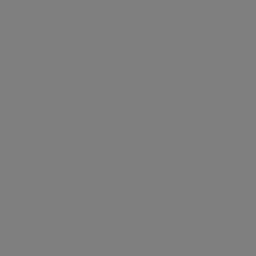

In [309]:
targets_vis = torch.zeros(layer_to_vis._andn_layer.output_shape())
targets_vis.view(-1)[targets.unique() - layer_to_vis._andn_layer.n_input_neurons()] = 0.5
to_pil_image(targets_vis.unsqueeze(0)).resize(
    [256, 256], Image.NEAREST
).show()

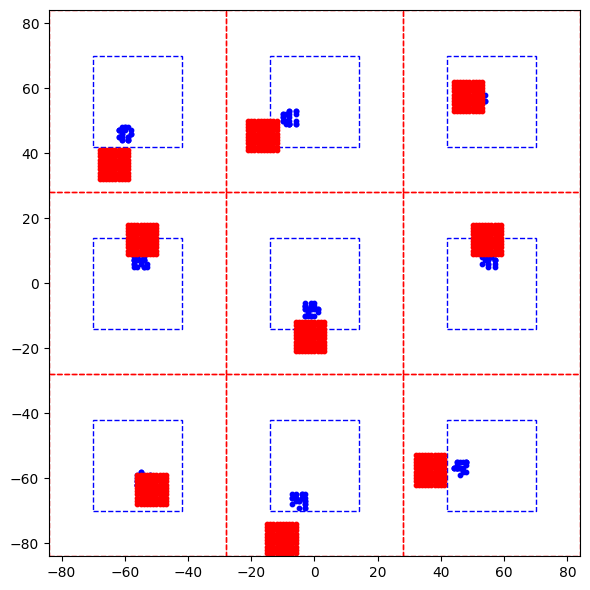

In [310]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

input_shape = layer_to_vis._input_shape
output_shape = layer_to_vis._andn_layer.output_shape()

plot_rectangle = (max(input_shape[0], output_shape[0]), max(input_shape[1], output_shape[1]))

iy = (torch.arange(input_shape[0], device=device) - input_shape[0] / 2) # * (plot_rectangle[0] / input_shape[0])
ix = (torch.arange(input_shape[1], device=device) - input_shape[1] / 2) # * (plot_rectangle[1] / input_shape[1])
grid_iy, grid_ix = torch.meshgrid(iy, ix, indexing='ij')
grid_iy = grid_iy.flatten()
grid_ix = grid_ix.flatten()

oy = (torch.arange(output_shape[0], device=device) - output_shape[0] / 2) # * (plot_rectangle[0] / output_shape[0])
ox = (torch.arange(output_shape[1], device=device) - output_shape[1] / 2) # * (plot_rectangle[1] / output_shape[1])
grid_oy, grid_ox = torch.meshgrid(oy, ox, indexing='ij')
grid_oy = grid_oy.flatten()
grid_ox = grid_ox.flatten()

plt.close()
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((-plot_rectangle[1] / 2) * grid_side, (plot_rectangle[1] / 2) * grid_side)
ax.set_ylim((-plot_rectangle[0] / 2) * grid_side, (plot_rectangle[0] / 2) * grid_side)

anchors = layer_to_vis._detector_anchors.reshape(layer_to_vis._n_detector_groups, -1).cpu()
for i in range(grid_side):
    for j in range(grid_side):
        center_x_shift = plot_rectangle[1] * (j - (grid_side / 2) + 0.5)
        center_y_shift = plot_rectangle[0] * ((grid_side / 2) - i - 0.5)
        rect = patches.Rectangle(
            (
                center_x_shift - output_shape[1] / 2,
                center_y_shift - output_shape[0] / 2
            ), output_shape[1], output_shape[0],
            fill=False, linestyle="--", linewidth=1, edgecolor="red"
        )
        ax.add_patch(rect)
        rect = patches.Rectangle(
            (
                center_x_shift - input_shape[1] / 2,
                center_y_shift - input_shape[0] / 2
            ), input_shape[1], input_shape[0],
            fill=False, linestyle="--", linewidth=1, edgecolor="blue"
        )
        ax.add_patch(rect)
        sample_id = sample_ids[i * grid_side + j]
        ys = -grid_iy[anchors[sample_id]] + center_y_shift
        xs = grid_ix[anchors[sample_id]] + center_x_shift
        ax.scatter(xs.cpu().numpy(), ys.cpu().numpy(), c="blue", s=10, label="set 1")
        ys = -grid_oy[sources_to_vis[sample_id * n_sources_per_detectors_group]] + center_y_shift
        xs = grid_ox[sources_to_vis[sample_id * n_sources_per_detectors_group]] + center_x_shift
        ax.scatter(xs.cpu().numpy(), ys.cpu().numpy(), c="red",  s=10, label="set 2")
plt.tight_layout()
plt.show()


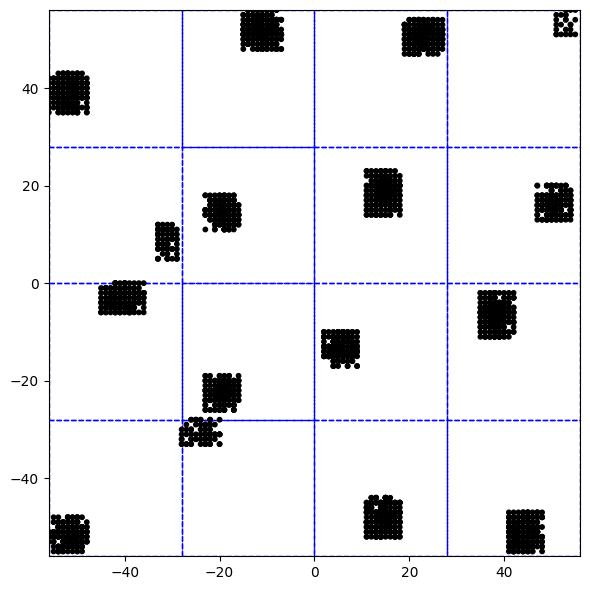

In [311]:
grid_side = 4
unique_targets = targets.unique()
targets_to_vis = unique_targets[torch.randperm(unique_targets.numel())][:grid_side**2].cpu()

anchors = layer_to_vis._detector_anchors.reshape(
    layer_to_vis._n_detector_groups * layer_to_vis._n_detectors_in_group, -1
).cpu()
sources_to_vis = {targets_to_vis[i].item(): dict() for i in range(grid_side**2)}

for s, t in zip(sources.cpu().numpy(), targets.cpu().numpy()):
    d = sources_to_vis.get(t)
    if d is not None:
        detector_id = s // LUTLayerBasic.n_lut_channels(layer_to_vis._n_anchors_per_detector, 1)
        if detector_id not in d:
            d[detector_id] = anchors[detector_id]

for t, d in sources_to_vis.items():
    sources_to_vis[t] = torch.cat(list(d.values())).cpu()

targets_to_vis = list(sources_to_vis.keys())
sources_to_vis = list(sources_to_vis.values())
colors_to_vis = [torch.zeros_like(s, dtype=torch.float32).unsqueeze(1).repeat(1, 3).cpu() for s in sources_to_vis]

# layered_andn_net.eval()
# with torch.no_grad():
#     bs = 256
#     test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=bs, shuffle=True)
#     for data, _ in test_loader:
#         layered_andn_net(data)
#         data = data.cpu()
        
#         for t, s, colors in zip(targets_to_vis, sources_to_vis, colors_to_vis):
#             for i in range(data.shape[0]):
#                 brightness = layered_andn_net._l1_res[i].view(-1)[t - layer_to_vis._andn_layer.n_input_neurons()].item()
#                 if brightness > 1.0:
#                     brightness = 1.0
#                 x = data[i].flatten()[s]
#                 colors[:,2:] += (x * brightness).unsqueeze(1)

# max_c = 0.0
# for c in colors_to_vis:
#     c /= len(mnist_test_dataset)
#     if c.max().item() > 1e-08:
#         c /= c.max()

input_shape = layer_to_vis._input_shape

iy = (torch.arange(input_shape[0], device=device) - input_shape[0] / 2) # * (plot_rectangle[0] / input_shape[0])
ix = (torch.arange(input_shape[1], device=device) - input_shape[1] / 2) # * (plot_rectangle[1] / input_shape[1])
grid_iy, grid_ix = torch.meshgrid(iy, ix, indexing='ij')
grid_iy = grid_iy.flatten()
grid_ix = grid_ix.flatten()
plt.close()

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim((-input_shape[1] / 2) * grid_side, (input_shape[1] / 2) * grid_side)
ax.set_ylim((-input_shape[0] / 2) * grid_side, (input_shape[0] / 2) * grid_side)

for i in range(grid_side):
    for j in range(grid_side):
        center_x_shift = input_shape[1] * (j - (grid_side / 2) + 0.5)
        center_y_shift = input_shape[0] * ((grid_side / 2) - i - 0.5)
        rect = patches.Rectangle(
            (
                center_x_shift - input_shape[1] / 2,
                center_y_shift - input_shape[0] / 2
            ), input_shape[1], input_shape[0],
            fill=False, linestyle="--", linewidth=1, edgecolor="blue"
        )
        ax.add_patch(rect)
        sample_id = i * grid_side + j
        ys = -grid_iy[sources_to_vis[sample_id]] + center_y_shift
        xs = grid_ix[sources_to_vis[sample_id]] + center_x_shift
        ax.scatter(xs.cpu().numpy(), ys.cpu().numpy(), c=colors_to_vis[sample_id], s=10, label="set 1")
plt.tight_layout()
plt.show()

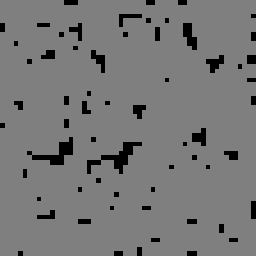

tensor(0.6831, device='cuda:5', grad_fn=<MulBackward0>)


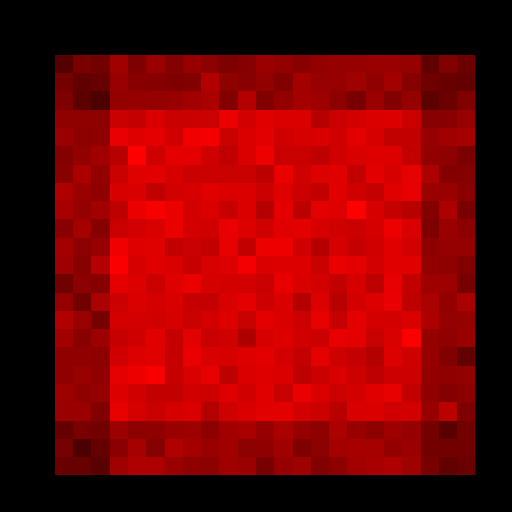

In [312]:
from spiky.util.visual_helpers import grayscale_to_red_and_blue

if layer_to_vis._inhibition_layer is not None:
    inhibition_vis = torch.zeros(layer_to_vis._inhibition_layer.output_shape())
    inhibition_vis.view(-1)[layer_to_vis._inhibition_layer._detectors] = 0.5
    to_pil_image(inhibition_vis.unsqueeze(0)).resize(
        [256, 256], Image.NEAREST
    ).show()

layered_andn_net(example_data)
l = layered_andn_net._l2_res[6]

img = grayscale_to_red_and_blue(l.unsqueeze(0), do_clip=False)
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
print(color_rescaler)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        512, 512
    ], Image.NEAREST
)

tensor(5.5364e-05, device='cuda:5')


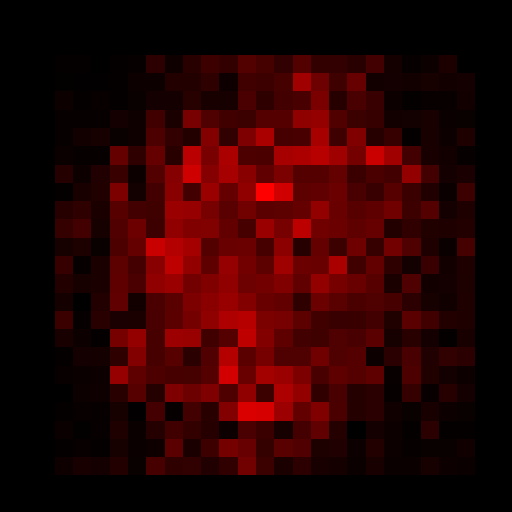

In [290]:
average_l = torch.zeros(layered_andn_net.layer2._andn_layer.output_shape(), device=device)

layered_andn_net.eval()
correct = 0
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
    for data, target in test_loader:
        output = layered_andn_net(data)
        average_l += layered_andn_net._l2_res.sum(dim=0)
        
l = average_l
img = grayscale_to_red_and_blue(l.unsqueeze(0), do_clip=False)
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
print(color_rescaler)
img = to_pil_image((img * color_rescaler).clip(0.0, 1.0))
img.resize(
    [
        512, 512
    ], Image.NEAREST
)

In [282]:
layer_to_vis

ANDNLUTLayerEx(input_shape=(56, 56), output_shape=(1, 32768), n_detectors=1024, n_anchors_per_detector=5)

In [248]:
train_accuracies = []
test_accuracies = []

In [275]:
optimizer = optim.Adam(layered_andn_net.parameters(), lr=0.001)


loss_func = nn.CrossEntropyLoss()
for epoch in range(8):
    layered_andn_net.train()
    train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = layered_andn_net(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_acc = 100. * correct / len(train_loader.dataset)
    layered_andn_net.eval()
    correct = 0
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=256, shuffle=True)
        for data, target in test_loader:
            output = layered_andn_net(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(
        f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}, '
        f'mean weights norm, layer 1: {mean_weights_norm(layered_andn_net.layer1):.5f}, '
        f'mean weights norm, layer 2: {mean_weights_norm(layered_andn_net.layer2):.5f}'
    )

Epoch 1 Train/test accuracy: 94.92/98.18, mean weights norm, layer 1: 1.13479, mean weights norm, layer 2: 1.57923
Epoch 2 Train/test accuracy: 98.90/98.16, mean weights norm, layer 1: 1.22223, mean weights norm, layer 2: 1.90618
Epoch 3 Train/test accuracy: 99.51/98.57, mean weights norm, layer 1: 1.28665, mean weights norm, layer 2: 2.13465
Epoch 4 Train/test accuracy: 99.73/98.27, mean weights norm, layer 1: 1.34602, mean weights norm, layer 2: 2.32795
Epoch 5 Train/test accuracy: 99.72/98.62, mean weights norm, layer 1: 1.41412, mean weights norm, layer 2: 2.53534
Epoch 6 Train/test accuracy: 99.82/97.90, mean weights norm, layer 1: 1.46731, mean weights norm, layer 2: 2.70026
Epoch 7 Train/test accuracy: 99.74/98.59, mean weights norm, layer 1: 1.53441, mean weights norm, layer 2: 2.90139
Epoch 8 Train/test accuracy: 99.88/98.36, mean weights norm, layer 1: 1.57697, mean weights norm, layer 2: 3.02701


In [85]:
layered_andn_net.layer1._andn_layer._backprop_hebb_ratio_on_torch_backward = 0.0

In [86]:
layered_andn_net.layer2._andn_layer._backprop_hebb_ratio_on_torch_backward = 0.0

# Training without hebb

first 8 epochs lr=0.01, the rest 96 lr=0.001

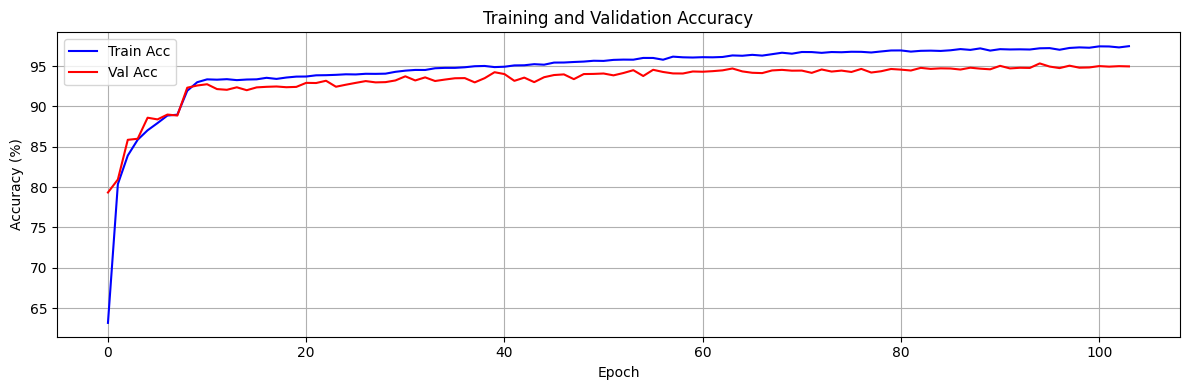

Best validation accuracy: 95.33% at epoch 95


In [239]:
# Plot training curves
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 4))

# Accuracy plot
ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(test_accuracies, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(test_accuracies):.2f}% at epoch {test_accuracies.index(max(test_accuracies))+1}")


# Same, zero initial weights

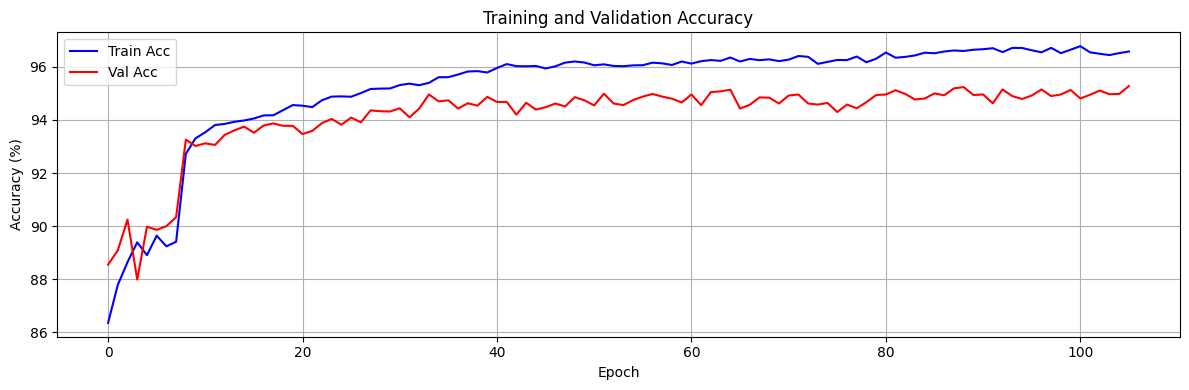

Best validation accuracy: 95.28% at epoch 106


In [50]:
# Plot training curves
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 4))

# Accuracy plot
ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(test_accuracies, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(test_accuracies):.2f}% at epoch {test_accuracies.index(max(test_accuracies))+1}")


# With hebbian "pretraining"

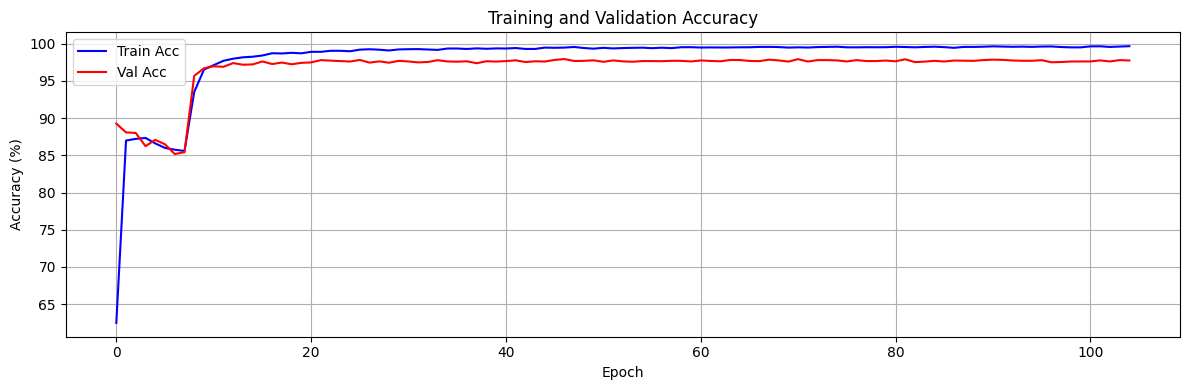

Best validation accuracy: 97.93% at epoch 47


In [79]:
# Plot training curves
fig, (ax2) = plt.subplots(1, 1, figsize=(12, 4))

# Accuracy plot
ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(test_accuracies, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(test_accuracies):.2f}% at epoch {test_accuracies.index(max(test_accuracies))+1}")
